In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#import nltk
import re
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

tf.__version__



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.5.0'

# Loading Data

In [2]:
data_dir = './input/'
print(os.listdir(data_dir))

['train.tsv', 'test.tsv.7z', 'test.tsv', 'train.tsv.7z', 'sample_submission.csv', 'sample_submission.csv.7z']


In [3]:
data = pd.read_csv(data_dir + 'train.tsv', delimiter='\t',encoding='utf-8')

In [4]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
#We have about 1.4M rows, and 8 columns
data.shape

(1482535, 8)

In [6]:
#Check for NAN columns
data.count()

train_id             1482535
name                 1482535
item_condition_id    1482535
category_name        1476208
brand_name            849853
price                1482535
shipping             1482535
item_description     1482531
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
#data['category_name'].value_counts(dropna=False)

In [ ]:
#data['brand_name'].value_counts(dropna=False)

# Preprocessing

In [8]:
def prepare_data():
    print('Preparing data')
    #replacing nan with '' value
    data['item_description'].fillna(value='', inplace=True)
    data['name'].fillna(value='', inplace=True)
    data['category_name'].fillna(value='', inplace=True)    
    data['brand_name'].fillna(value='', inplace=True)
    
    #creating general text column that combine all text columns that has no specific meaning/names.
    data['text'] =data['item_description']+ ' ' + data['name'] + ' ' +data['category_name'].str.replace('/', ' ')
    #the brand_text column will be treated differently when building vocabulary.  
    data['brand_text']=data['brand_name'].str.upper()

    



In [ ]:
#stopwords = nltk.corpus.stopwords.words('english') 
#stemmer = nltk.stem.snowball.SnowballStemmer('english')



In [9]:

def clean_text (text, lower=True):
    # Basic text cleaning:  Either lowering or capitalizing words, 
    # and using alphabet without special characters.
    if lower:
        clean_text = re.sub("[^a-zA-Z]", " ", text.lower().strip())
    else:
        clean_text = re.sub("[^a-zA-Z]", " ", text.upper().strip())
    
    #  Filtering out  words that are less than 3 chars
    #filtered_words= [word for word in clean_text.split(" ") if word not in stopwords and len(word) > 2]
    filtered_words=(" ").join([word for word in clean_text.split(" ") if len(word) > 2])
  
    (" ").join(filtered_words)
    
    return filtered_words  

In [ ]:
data.iloc[[1 ] ,7]

In [10]:
prepare_data()

Preparing data


In [11]:
clean_text_1 = data.apply(lambda x: clean_text(x['text'], lower=True), axis=1)

In [12]:
clean_text_1[1]

'this keyboard great condition and works like came out the box all the ports are tested and work perfectly the lights are customizable via the razer synapse app your razer blackwidow chroma keyboard electronics computers tablets components parts'

In [13]:
#Tokenization:
POP_WORDS = 10000  #We'll tokenize only the most 10000 popular words.  
tokenizer = Tokenizer(num_words=POP_WORDS) #, lower=False)

In [14]:
%time
tokenizer.fit_on_texts(clean_text_1) #+' '+ data['brand_text'] )
#To work on tokenize brand name as having separate meaning, than blending in with other text.

#The Workaround for tokenizer num_words issue: https://github.com/keras-team/keras/issues/8092
#Take the first 10000 most frequently used words.
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= POP_WORDS}

vocab_size = len(tokenizer.word_index)

x_train_tokens = tokenizer.texts_to_sequences(clean_text_1) #+ ' '+ data['brand_text'] )

#x_train_tokens[:3]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [15]:
type(x_train_tokens)

list

In [16]:
vocab_size 

10000

In [17]:
tokenizer.word_index

{'tyler': 6617,
 'revival': 1689,
 'ebay': 3777,
 'hearts': 1434,
 'capable': 7088,
 'progress': 3093,
 'burt': 5505,
 'journals': 8005,
 'measurement': 2879,
 'hobo': 3049,
 'pierre': 9926,
 'imagine': 6288,
 'sunny': 5287,
 'meditate': 9297,
 'conversation': 7884,
 'marcus': 7042,
 'saiyan': 7992,
 'volcom': 4174,
 'surge': 5516,
 'dslr': 9390,
 'vision': 4676,
 'tiles': 9721,
 'colorblends': 3751,
 'pockets': 309,
 'buttoned': 6532,
 'ochre': 8433,
 'customized': 3766,
 'sleeves': 542,
 'gta': 4538,
 'pie': 2656,
 'spirituality': 6427,
 'tsp': 8182,
 'bliss': 5061,
 'goku': 7289,
 'masters': 7519,
 'sku': 8948,
 'ipads': 7604,
 'mate': 4681,
 'difference': 3749,
 'exterior': 1614,
 'anymore': 896,
 'logos': 4496,
 'flask': 6856,
 'sands': 8941,
 'fine': 740,
 'tweed': 7724,
 'fossil': 1707,
 'fallen': 8070,
 'illuminator': 4913,
 'swaddles': 9197,
 'expansion': 6137,
 'shoelaces': 8738,
 'strip': 2501,
 'frequently': 7219,
 'cinnamon': 3107,
 'environmentally': 9950,
 'moss': 6549,


In [18]:
data['text_seq']=x_train_tokens
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,text,brand_text,text_seq
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet,No description yet MLB Cincinnati Reds T Shirt...,,"[63, 75, 2288, 8026, 6347, 73, 6, 29, 28, 51]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,This keyboard is in great condition and works ...,RAZER,"[20, 2527, 33, 11, 1, 206, 48, 1104, 59, 3, 54..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Adorable top with a hint of lace and a key hol...,TARGET,"[628, 52, 7, 4976, 194, 1, 894, 1276, 3, 107, ..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,,35.0,1,New with tags. Leather horses. Retail for [rm]...,New with tags. Leather horses. Retail for [rm]...,,"[5, 7, 58, 180, 6016, 233, 4, 164, 1077, 224, ..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,,44.0,0,Complete with certificate of authenticity,Complete with certificate of authenticity 24K ...,,"[827, 7, 6368, 1922, 101, 1035, 282, 2, 80, 292]"


In [19]:
tokenizer.document_count

1482535

In [20]:
#print(tokenizer.word_counts["PINK"])
print(tokenizer.word_index.get("pink"))

#List top 100 words used in description and visualize

16


In [21]:
len_seq_text=data.text_seq.apply(lambda x: len(x))

In [22]:
data['len_text_seq'] = len_seq_text

In [23]:
data.head()


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,text,brand_text,text_seq,len_text_seq
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,,10.0,1,No description yet,No description yet MLB Cincinnati Reds T Shirt...,,"[63, 75, 2288, 8026, 6347, 73, 6, 29, 28, 51]",10
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,This keyboard is in great condition and works ...,RAZER,"[20, 2527, 33, 11, 1, 206, 48, 1104, 59, 3, 54...",35
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Adorable top with a hint of lace and a key hol...,TARGET,"[628, 52, 7, 4976, 194, 1, 894, 1276, 3, 107, ...",25
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,,35.0,1,New with tags. Leather horses. Retail for [rm]...,New with tags. Leather horses. Retail for [rm]...,,"[5, 7, 58, 180, 6016, 233, 4, 164, 1077, 224, ...",36
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,,44.0,0,Complete with certificate of authenticity,Complete with certificate of authenticity 24K ...,,"[827, 7, 6368, 1922, 101, 1035, 282, 2, 80, 292]",10


In [24]:
data['len_text_seq'].describe()

count    1.482535e+06
mean     2.771055e+01
std      2.333512e+01
min      0.000000e+00
25%      1.300000e+01
50%      2.000000e+01
75%      3.200000e+01
max      1.710000e+02
Name: len_text_seq, dtype: float64

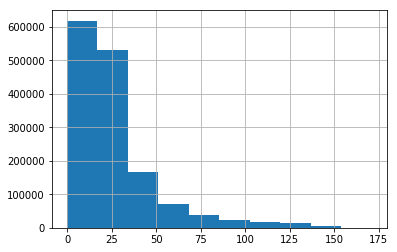

In [25]:
data['len_text_seq'].hist()
plt.show()

For our embedding, RNN needs these inputs:

input_dim:  This is our vocab_size.
output_dim:  This is the size of our output embedded vector.  We will use 50.
input_length:  This is bucket_len that we must choose as below.

To choose the bucket len, we observe:
Mean , std , and max.  There is a big difference between mean/std from max.  
To choose the word bucket length for our RNN input, 
we can take 2 standard deviation from the mean length as word bucket length.
That covers about 95% of the data.  We'll trim 5% of data, that have above selected length,
and pad 95% of the data to the selected bucket length.


In [26]:

bucket_len= int(np.mean(data['len_text_seq']) + 2 * np.std(data['len_text_seq']))
print("bucket len:  " + str(bucket_len))
print("Data % less than len:  " 
      +str(np.sum(data['len_text_seq'] < bucket_len) / len(data['len_text_seq'])))

bucket len:  74
Data % less than len:  0.9432580006542847


In [27]:
#setting up test/train data:

text_seq_pad = pad_sequences(data['text_seq'], maxlen=bucket_len)

Y = np.log(data["price"] + 1)
Y=Y.values.reshape((Y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(text_seq_pad, Y, test_size=0.20, random_state=42)
text_seq_pad.shape


(1482535, 74)

In [28]:
print(text_seq_pad[:2])


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   63   75 2288 8026 6347   73
     6   29   28   51]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   20 2527   33
    11    1  206   48 1104   59    3   54   27    3 3020   17  772    1
   382  732    3 1182   17 7119 1257    3 9726 1595   45 9726 2527   44
   832  745 3009 1246]]


In [29]:
#print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1186028, 74)
(296507, 74)
(1186028, 1)
(296507, 1)


In [30]:
X_train[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   23,   94,  128,
          33,   11,   66,   21,   38,   21,  103,  391],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    9,    5,   18, 1148,   19,   19,   19]

In [31]:
y_train[:3]

array([[2.77258872],
       [3.80666249],
       [3.58351894]])

In [32]:
model=Sequential()


In [33]:
output_embedding=50

model.add(Embedding(input_dim=vocab_size, output_dim=output_embedding, input_length=bucket_len))

model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))

model.add(GRU(units=64))
model.add(Dense(1,activation="linear"))

optimizer = Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 74, 50)            500000    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         68736     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37056     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 630,625
Trainable params: 630,625
Non-trainable params: 0
________________________________________________________

In [34]:
%%time
EPOCH_NUM = 2
BATCH_SIZE= 4096

model.fit(X_train, y_train,
          epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_split=0.05)

Train on 1126726 samples, validate on 59302 samples
Epoch 1/2
1126726/1126726 [==============================]1126726/1126726 [==============================] - 2491s 2ms/step - loss: 0.5314 - val_loss: 0.3113

Epoch 2/2
1126726/1126726 [==============================]1126726/1126726 [==============================] - 1996s 2ms/step - loss: 0.2822 - val_loss: 0.2753

CPU times: user 1h 49min 15s, sys: 19min 58s, total: 2h 9min 13s
Wall time: 1h 14min 48s


In [35]:
model.save_weights("V1_Mercari_Price_Prediction_GRU.h5")


In [36]:
def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

In [37]:
%%time

print("Evaluating the model on validation data...")
Y_test_preds_rnn = model.predict(X_test[:230000], batch_size=BATCH_SIZE)

Evaluating the model on validation data...
CPU times: user 4min 9s, sys: 34 s, total: 4min 43s
Wall time: 2min 27s


In [38]:
print(" RMSLE error:", rmsle(y_test[:230000], Y_test_preds_rnn))

 RMSLE error: 0.530756324336218


In [39]:
Y_test_preds_rnn.shape

(230000, 1)